# Nested sampling

In the [MCMC tutorial](./mcmc.html), Bayes theorem was shown, 

$$ p = \frac{P L}{Z}, $$

where where, $p$ is the posterior probability, $P$ is the prior probability, $L$ is the likelihood, and $Z$ is the evidence. 
Normally, in the evaluation of the posterior probability, the evidence is removed as a constant of propertionality. 
This is due to the fact that it is a single value for a given model and dataset pair. 

However, sometimes it is desirable to find the evidence for a model to a given dataset.
In particular, when we want to compare the evidence for a series of models, to determine which best describes the dataset.
In order to achieve this, `uravu` is able to perform [nested sampling](https://doi.org/10.1063/1.1835238) to estimate the Bayesian evidence for a model given a particular dataset. 

This tutorial will show how this is achieved, and show the utility of Bayesian model selection. 

However, as always we must first create some *synthetic* data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from uravu.distribution import Distribution
from uravu.relationship import Relationship
from uravu import plotting, utils

In [2]:
np.random.seed(2)

This synthetic data is log-normally distributed in the ordinate. 
See [distributions](./distributions.html) tutorial to find out defining non-normally distributed data. 

In [3]:
x = np.linspace(10, 50, 20)
y = .3 * x ** 2 - 1.4 * x + .2
Y = []
for i in y:
    Y.append(Distribution(lognorm.rvs(s=2, loc=i, scale=1, size=1000)))

From looking at the code used to synthesize this data, it is clear that the functional from of the model is a quadratic polynomial. 
However, if this was data collected from some measurement and the physical theory suggests it should be analysed with a polynormial of unknown degree then Bayesian model selection would be the ideal tool to find the best model. 

Let's quickly write a few models to perform the `n` degree polynomial analysis with. 

In [4]:
def one_degree(x, a, b):
    return b * x + a

def two_degree(x, a, b, c):
    return c * x ** 2 + b * x + a

def three_degree(x, a, b, c, d):
    return d * x ** 3 + c * x ** 2 + b * x + a

def four_degree(x, a, b, c, d, e):
    return e * x ** 4 + d * x ** 3 + c * x ** 2 + b * x + a

With these functions defined, we can now build the `Relationship` objects for each of the functions. 

In [5]:
one_modeller = Relationship(one_degree, x, Y, 
                            bounds=((-300, 0), (-2, 20)))
one_modeller.max_likelihood('diff_evo')

In [6]:
two_modeller = Relationship(two_degree, x, Y, 
                            bounds=((-2, 2), (-2, 2), (-1, 1)))
two_modeller.max_likelihood('diff_evo')

In [7]:
three_modeller = Relationship(three_degree, x, Y, 
                              bounds=((-2, 2), (-2, 2), (-1, 1), (-0.2, 0.2)))
three_modeller.max_likelihood('diff_evo')

In [8]:
four_modeller = Relationship(four_degree, x, Y, 
                             bounds=((-2, 2), (-2, 2), (-1, 1), (-0.2, 0.2), (-0.02, 0.02)))
four_modeller.max_likelihood('diff_evo')

Having built these, lets see what the maximum likelihood variables are for each. 

In [9]:
print(one_modeller.variable_medians)

[-245.49075453   17.69708446]


In [10]:
print(two_modeller.variable_medians)

[ 0.92673225 -1.28344677  0.29831624]


In [11]:
print(three_modeller.variable_medians)

[ 1.12171456e+00 -1.50994256e+00  3.11896641e-01 -1.85985620e-04]


In [12]:
print(four_modeller.variable_medians)

[ 3.50408477e-01 -9.58251997e-01  2.64924917e-01  1.09249940e-03
 -1.10893799e-05]


It is possible to quickly visualise the relationship with the `plotting` function, which shows the log-normal distribution of the ordinate data. 

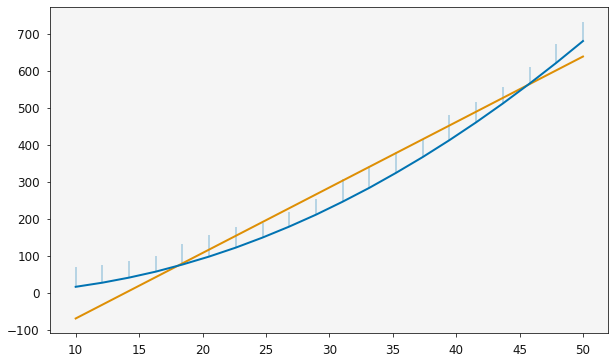

In [13]:
plotting.plot_relationship(one_modeller)
plt.show()

We can see that the highest order terms are quite small for the larger degree of polynomial. 
Let's see what effect this has on the evidence. 

Note that `uravu` and `dynesty` calculates the natural log of the evidence, $\ln{Z}$. 

In [14]:
one_modeller.nested_sampling()

3426it [00:15, 218.67it/s, +500 | bound: 5 | nc: 1 | ncall: 21338 | eff(%): 18.399 | loglstar:   -inf < -123.515 <    inf | logz: -129.507 +/-  0.140 | dlogz:  0.001 >  0.509]


In [15]:
two_modeller.nested_sampling()

3790it [00:23, 159.11it/s, +500 | bound: 7 | nc: 1 | ncall: 22819 | eff(%): 18.800 | loglstar:   -inf < -82.248 <    inf | logz: -88.982 +/-  0.150 | dlogz:  0.001 >  0.509]


In [16]:
three_modeller.nested_sampling()

6147it [00:46, 131.77it/s, +500 | bound: 16 | nc: 1 | ncall: 30273 | eff(%): 21.957 | loglstar:   -inf < -84.756 <    inf | logz: -96.245 +/-  0.207 | dlogz:  0.001 >  0.509]   


In [17]:
four_modeller.nested_sampling()

9083it [01:12, 125.81it/s, +500 | bound: 29 | nc: 1 | ncall: 39979 | eff(%): 23.970 | loglstar:   -inf < -81.820 <    inf | logz: -99.205 +/-  0.261 | dlogz:  0.001 >  0.509]     


Having estimated $\ln{Z}$ for each `Relationship`, lets plot them as a function of the number of variables in the model.

In [18]:
variables = [len(one_modeller.variables), len(two_modeller.variables),
             len(three_modeller.variables), len(four_modeller.variables)]
ln_evidence = [one_modeller.ln_evidence.n, two_modeller.ln_evidence.n,
               three_modeller.ln_evidence.n, four_modeller.ln_evidence.n]
ln_evidence_err = [one_modeller.ln_evidence.s, two_modeller.ln_evidence.s,
                   three_modeller.ln_evidence.s, four_modeller.ln_evidence.s]

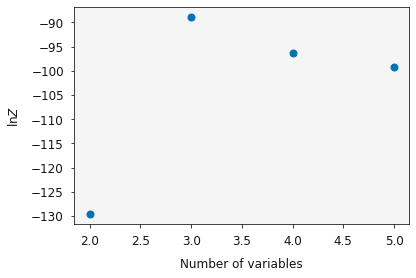

In [19]:
plt.errorbar(variables, ln_evidence, ln_evidence_err, marker='o', ls='')
plt.xlabel('Number of variables')
plt.ylabel(r'$\ln{Z}$')
plt.show()

We can see that the evidence reaches a maxiumum at 3 variables (the `two_degree` model), this indicates that this is the most probable model for analysis of this dataset. 

Finally, we can use some build in functionality of `uravu` to compare different evidence values, in a value known as the [Bayes factor](https://doi.org/10.2307/2291091). 
Let's compare the `one_degree` and `two_degree` models.

In [21]:
print(utils.bayes_factor(two_modeller.ln_evidence, one_modeller.ln_evidence))

81.0+/-0.4


The Bayes factor between the two and one degree models, $2\ln{B_{21}}$, has a value of $\sim81$. 
The Table in [Kass and Raftery](https://doi.org/10.2307/2291091) suggests that this shows "Strong" evidence for the model with more variables (the `two_degree` model). 

This means that it is sensible to go ahead and use the `two_degree` model in the further analysis of our data, using MCMC for example. 

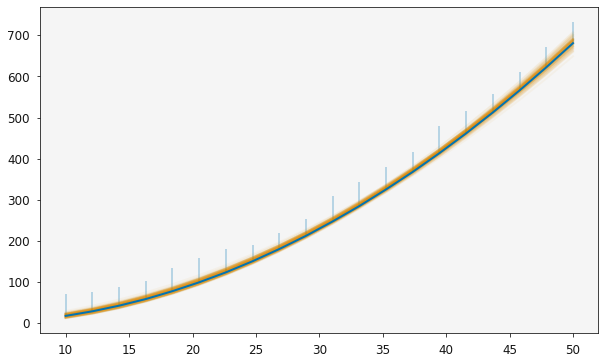

In [22]:
plotting.plot_relationship(two_modeller)
plt.show()